[[23.71700668 27.58161545 30.04733467 31.62024117 32.50028992 32.78401947
  32.50028992 31.62024117 30.04733467 27.58161545 23.71700668]
 [27.58161545 35.87323761 41.38331223 44.92599869 46.91690063 47.55976105
  46.91690063 44.92599869 41.38331223 35.87323761 27.58161545]
 [30.04733467 41.38331223 49.24437332 54.39037704 57.30515671 58.24935913
  57.30515671 54.39037704 49.24437332 41.38331223 30.04733467]
 [31.62024117 44.92599869 54.39037704 60.68238831 64.27451324 65.4419632
  64.27451324 60.68238831 54.39037704 44.92599869 31.62024117]
 [32.50028992 46.91690063 57.30515671 64.27451324 68.27462006 69.5777359
  68.27462006 64.27451324 57.30515671 46.91690063 32.50028992]
 [32.78401947 47.55976105 58.24935913 65.4419632  69.5777359  70.92617798
  69.5777359  65.4419632  58.24935913 47.55976105 32.78401947]
 [32.50028992 46.91690063 57.30515671 64.27451324 68.27462006 69.5777359
  68.27462006 64.27451324 57.30515671 46.91690063 32.50028992]
 [31.62024117 44.92599869 54.39037704 60.682

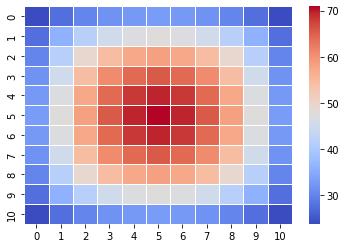

In [3]:
#Archivo donde se llama a la funcion galerkin y se hacen pruebas numericas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Mesh import * #Archivo donde esta la función para generar malla y para graficar
from sympy import integrate, linear_eq_to_matrix, symbols,simplify,collect,  diff, Eq, Matrix
from sympy import *
from GalerkinFuntion import *

from numpy import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

#from GalerkinFuntionNormalizado import *

l = 0.8 #Distancia en x
#l=symbols('l')
w = 0.8 #Distancia en y
#w=symbols('w')
p = 10  #Divisiones en x
m = 10  #Divisiones en y

elemLength = l/p #Largo del elemento
elemWidth = w/m  #Ancho del elemento
tipoDeElemento = 'CUADRADO' #Puede ser elemento tipo 'TRIANGULO' o 'CUADRADO'

#Se genera la lista NL ("Node list") que contiene las coordenadas de cada nodo
#y EL("Element list") que contiene la lista de nodos de cada elemento

NL,EL = uniform_mesh(l, w, p, m, tipoDeElemento) # Generar malla

# graph_mesh(tipoDeElemento,NL,EL) #Graficar malla

#Definicion de condiciones iniciales

#kx=symbols('kx')
kx=1.2 #k conductividad en y
#ky=symbols('kx')
ky=1.2 #k conductividad en X

#Para caso donde la superficie es fuente de calor
#h=symbols('h')
h=20 #h Coeficiente de conveccion
#Tf=symbols('Tf')
Tf=20 #Tf Temperatura del aire 
#q=symbols('q')
q=1000 #q Flujo especifico de calor Vatios/m3  

#Para caso donde el calor viene del ambiente:
# h=-20 #h Coeficiente de conveccion
# Tf=100 #Tf Temperatura del aire 
# q=-100 #q Flujo especifico de calor Vatios/m3 




eqSist=[]
dataFrame=pd.DataFrame()

listaLadosConv=[True,True,True,True] #Lados i-j, j-m, m-n, n-i Lista con lados con conv

dataFrameList = []  #Se juntan las dataframe de cada elemento en una lista dataFrameList
for i in range (0, len(EL)):
    dataFrameList.append(galerkinMethod(elemLength, elemWidth, NL, EL, h, Tf, kx, ky, q, i,l,w, listaLadosConv ))

#print(dataFrameList)

#Nuevo dataframe juntando todas las dataFrame con elementos. Teniendo 4x#El ecuaciones
DataFrame = pd.concat(dataFrameList, axis=0)

#Las ecuaciones se suma deacuerdo a los nodos, para tener #Nodos ecuaciones
CompressedDF = DataFrame.replace(np.nan,0) #0 donde no hay termino
CompressedDF = DataFrame.groupby("nodo").sum() #suma por columna nodo
#CompressedDF.to_excel("ef.xlsx") #Para visualizar dataFrame comprimido
#DataFrame.to_excel ("ef2.xlsx" ) #Para visualizar dataFrame original

#Generación de matrices
matrixFinal = np.matrix(CompressedDF.drop('indep', inplace=False, axis=1)) #Matriz de coeff final
vectorFinal = np.array(CompressedDF['indep']) #Vector independiente para la solucion 
CompressedDF.drop('indep', inplace=True, axis=1) #Eliminamos de CompressedDF la columna indep
TemperatureVector =np.array(CompressedDF.columns ) #Se genera un vector con las incognitas


#print(matrixFinal)
#print(vectorFinal)

#Se genera una lista para guardar como incognitas las temperaturas
listaTemperaturas=[]
listaprueba=[]
listaprueba2=[]
for i in TemperatureVector:
    listaTemperaturas.append(symbols(str(i)))
    listaprueba.append(str(i))

for ele in listaprueba:
  listaprueba2.append(int(ele[1:]))

#Para usar la funcion linsolve de numpy 
vectorFinal = vectorFinal.astype('float32')
matrixFinal = matrixFinal.astype('float32')

# print(TemperatureVector)
#Se resuelve el sistema de ecuaciones
result=np.linalg.solve(matrixFinal, vectorFinal)
# print(result)

matrixCalor = np.zeros((p+1, m+1))


listaSinOrden=[]
for i in range (0,len(listaprueba2)):
  listaSinOrden.append([listaprueba2[i],result[i]])

def getKey(item):
  return item[0]

listaOrdenada=sorted(listaSinOrden, key=getKey)

# print(listaOrdenada)

contador=0
for j in range(0,m+1):
    for i in range (0,p+1):
        matrixCalor[j,i]=listaOrdenada[contador][1]
        contador=contador+1

print(matrixCalor)

# plt.imshow(matrixCalor, cmap='hot', interpolation='nearest')
# plt.show()

ax = sns.heatmap(matrixCalor, linewidth=0.5,cmap="coolwarm")


plt.show()